In [321]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression



# MLP Scaling

In [360]:
df = pd.read_csv('new_scheduler_linear_scaling.csv')
avg_scaling_df = df.groupby(['model_size', 'step']).mean()
min_scaling_df = df.groupby(['model_size', 'step']).min()
avg_scaling_df

Unnamed: 0.1  Unnamed: 0        lr  train_loss  \
model_size step                                                        
3.66       12672.0          6000.0      6000.0  0.026135    0.360094   
           25472.0          6001.0      6001.0  0.026135    0.320895   
           38272.0          6002.0      6002.0  0.026135    0.250057   
           51072.0          6003.0      6003.0  0.026135    0.266116   
           63872.0          6004.0      6004.0  0.026135    0.264786   
...                            ...         ...       ...         ...   
2048.00    1868672.0        1795.0      1795.0  0.001105    0.001977   
           1881472.0        1796.0      1796.0  0.001105    0.007758   
           1894272.0        1797.0      1797.0  0.001105    0.001727   
           1907072.0        1798.0      1798.0  0.001105    0.003023   
           1919872.0        1799.0      1799.0  0.001105    0.003173   

                      eval_loss  eval_min  train_min       compute     params  
model_size step                                                                
3.66       12672.0     0.378484  0.378484   0.360094  2.172788e+07       13.0  
           25472.0     0.303744  0.303744   0.282568  4.367523e+07       13.0  
           38272.0     0.282439  0.282169   0.239267  6.562258e+07       13.0  
           51072.0     0.255440  0.253723   0.221332  8.756993e+07       13.0  
           63872.0     0.236608  0.233814   0.213312  1.095173e+08       13.0  
...                         ...       ...        ...           ...        ...  
2048.00    1868672.0   0.053040  0.050333   0.000107  1.003236e+15  4194304.0  
           1881472.0   0.052617  0.050333   0.000107  1.010108e+15  4194304.0  
           1894272.0   0.053383  0.050333   0.000107  1.016980e+15  4194304.0  
           1907072.0   0.052728  0.050322   0.000107  1.023851e+15  4194304.0  
           1919872.0   0.052676  0.050322   0.000107  1.030723e+15  4194304.0  

[3600 rows x 9 columns]

In [361]:
cmap = sns.blend_palette(['black', "firebrick", 'orange', 'green' ], 24) 

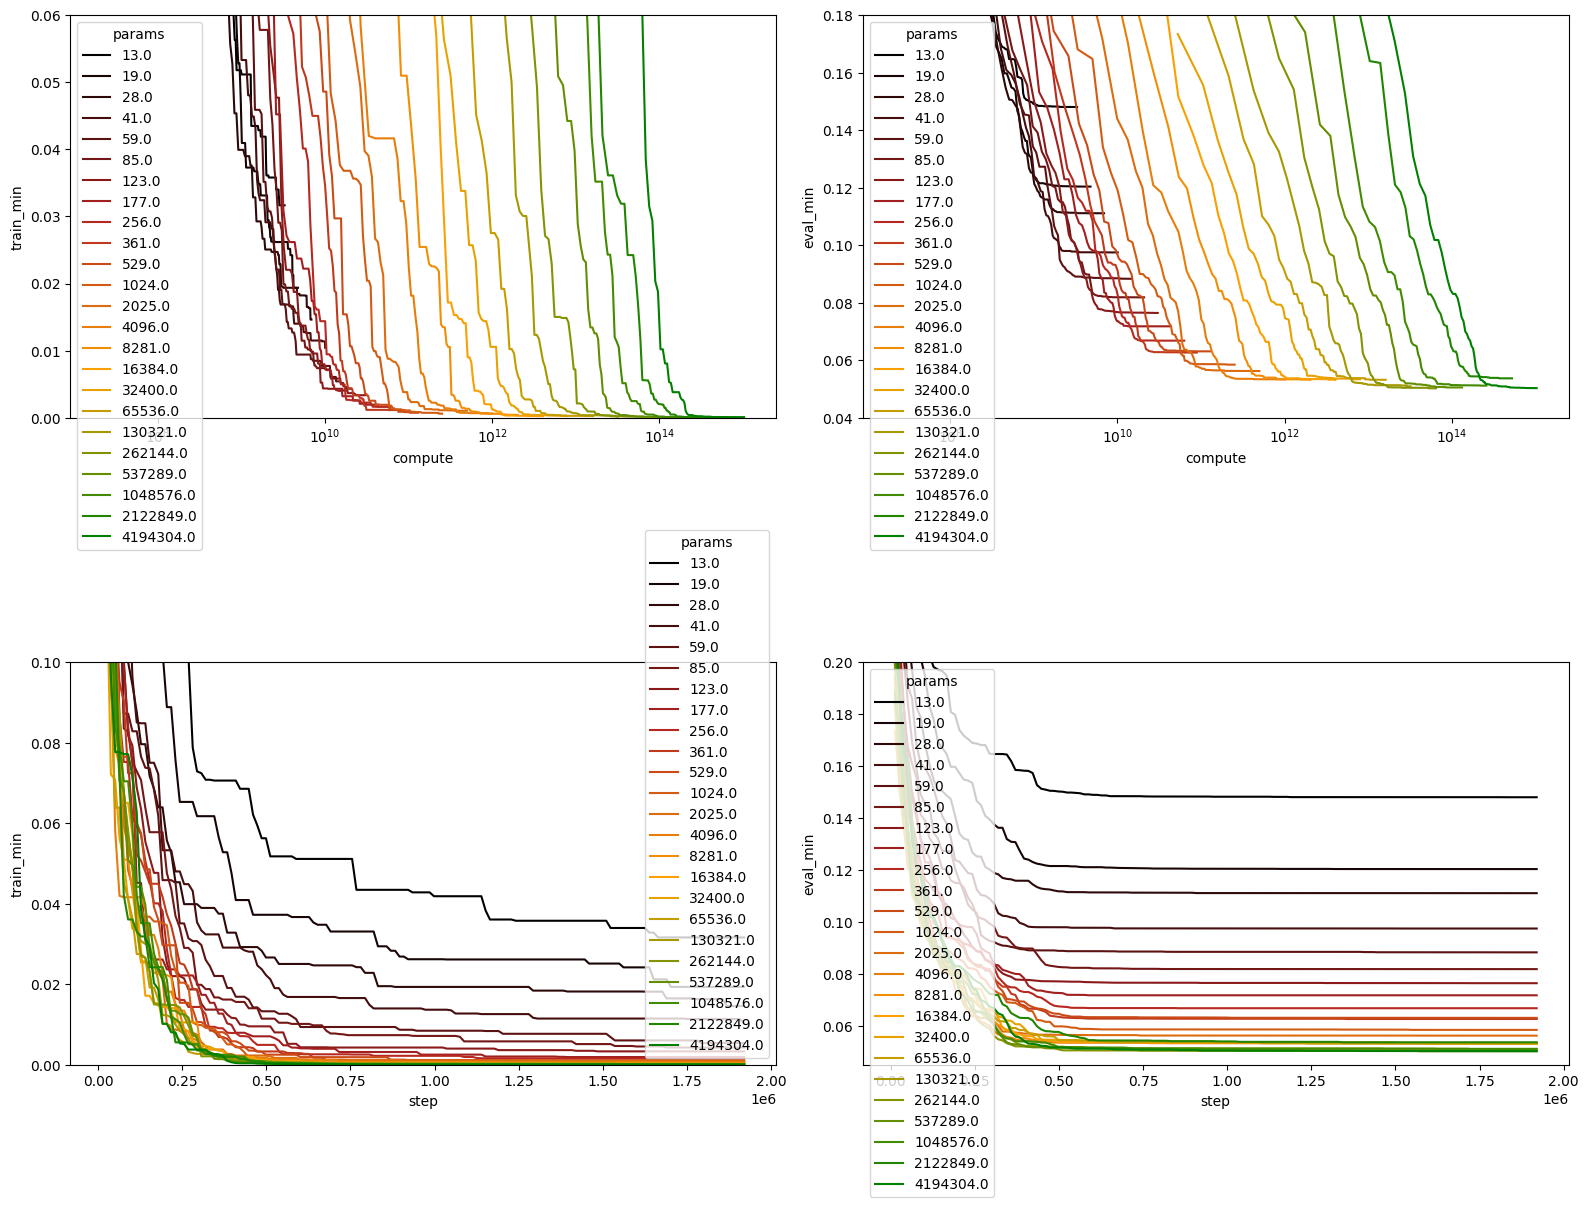

In [362]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
ax = ax.flatten()

sns.lineplot(data=avg_scaling_df, x = 'compute', y='train_min', hue='params', palette=cmap, ax=ax[0])
sns.lineplot(data=avg_scaling_df, x = 'compute', y='eval_min', hue='params',  palette=cmap, ax=ax[1])
sns.lineplot(data=avg_scaling_df, x = 'step', y='train_min', hue='params', palette=cmap, ax=ax[2])
sns.lineplot(data=avg_scaling_df, x = 'step', y='eval_min', hue='params', palette=cmap,  ax=ax[3])
for i in range(2):
    ax[i].set_xscale('log')
ax[0].set_ylim(0, .06)
ax[1].set_ylim(.04, .18)
ax[2].set_ylim(0, .1)
ax[3].set_ylim(.045, .2)


plt.tight_layout()

With more available flops, bigger models become optimal.

Bigger are always more data efficient, and they "exhaust" data more quickly than smaller models.

Around 10k parameters the architecture hits its apparent limit. 

Note the curvature in the flops-loss frontier

## Approach 1 from Chinchilla Paper

In [345]:
compute_efficient_df = pd.DataFrame({'Compute': [], 'Model Size': [], 'Steps': []})
compute_efficient_df['Compute'] = [avg_scaling_df['compute'].unique()[i] for i in range(0, len(avg_scaling_df), 10)]

efficient_models = []
efficient_steps = []
for compute in compute_efficient_df['Compute']:
    efficient_models.append(avg_scaling_df[avg_scaling_df.loc[avg_scaling_df['compute'] <= compute]['eval_loss'].min() == avg_scaling_df.eval_loss]['params'].values.item())
    efficient_steps.append(avg_scaling_df[avg_scaling_df.loc[avg_scaling_df['compute'] <= compute]['eval_loss'].min() == avg_scaling_df.eval_loss].index[0][1])
compute_efficient_df['Model Size'] = efficient_models
compute_efficient_df['Steps'] = efficient_steps

compute_efficient_df['log Compute'] = np.log10(compute_efficient_df.Compute)
compute_efficient_df['log Model Size'] = np.log10(compute_efficient_df['Model Size'])
compute_efficient_df['log Steps'] = np.log10(compute_efficient_df.Steps)

partial_df = compute_efficient_df[compute_efficient_df.Compute.between(1e9, 2e11)]

reg1 = LinearRegression().fit(partial_df['log Compute'].values.reshape(-1, 1), partial_df['log Model Size'].values)
reg2 = LinearRegression().fit(partial_df['log Compute'].values.reshape(-1, 1), partial_df['log Steps'].values)

reg1.coef_.item()


0.849806568524032

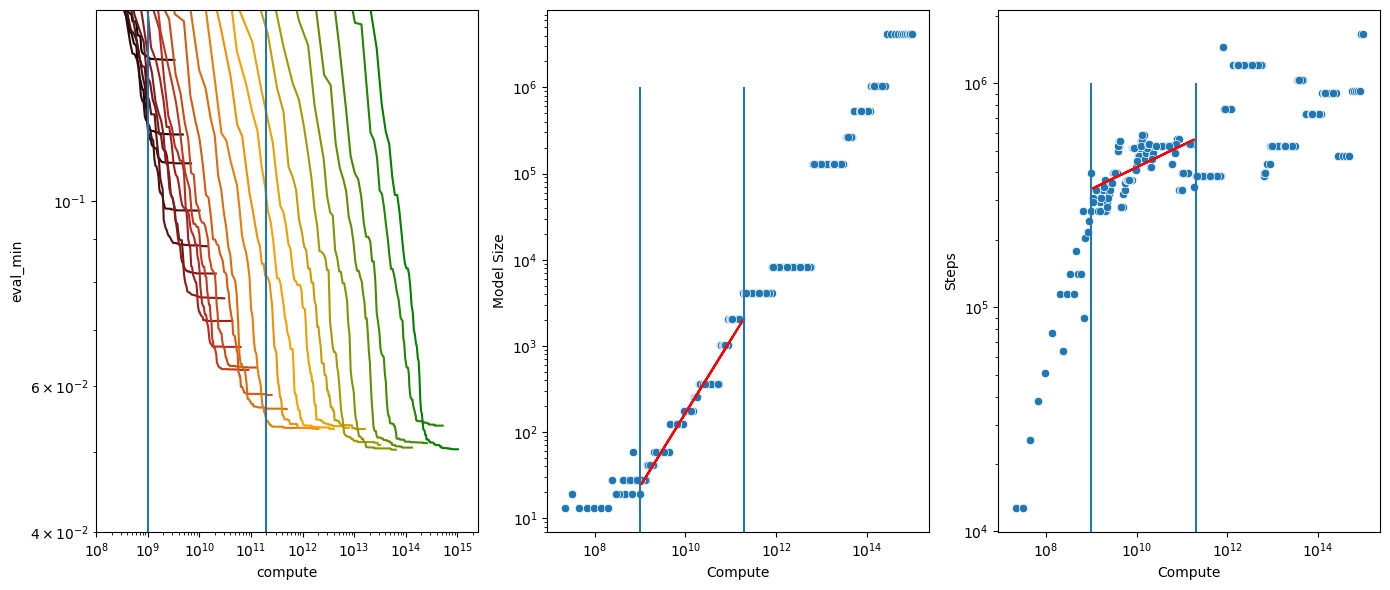

In [353]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 6))
ax = ax.flatten()

sns.lineplot(data=avg_scaling_df, x = 'compute', y='eval_min', hue='params',  palette=cmap, ax=ax[0]).legend_.remove()

sns.scatterplot(data=compute_efficient_df, x = 'Compute', y='Model Size', ax=ax[1])
ax[1].plot(partial_df['Compute'], partial_df['Compute']**reg1.coef_ * 10**reg1.intercept_, color='r')

sns.scatterplot(data=compute_efficient_df, x = 'Compute', y='Steps', ax=ax[2])
ax[2].plot(partial_df['Compute'], partial_df['Compute']**reg2.coef_ * 10**reg2.intercept_, color='r')

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].vlines(x=1e9, ymin=0, ymax=1e6)
    ax[i].vlines(x=2e11, ymin=0, ymax=1e6)

ax[0].set_xlim(1e8,)

ax[0].set_ylim(.04, .17)


plt.legend([],[], frameon=False)

plt.tight_layout()

Discussion of the Vertical Lines

The limited window of a clear scaling regime

The limited significance of the data scaling line given the nature of the data

Results: formulae for optimal model size and data

# CNN Scaling

In [363]:
df = pd.read_csv('complete_scaling_data.csv')
avg_scaling_df = df.groupby(['model_size', 'step']).mean()
min_scaling_df = df.groupby(['model_size', 'step']).min()
avg_scaling_df

Unnamed: 0  train_loss  eval_loss       compute  eval_min  \
model_size step                                                                 
1.0        12672         852.4    0.307533   0.268093  1.622016e+06  0.210167   
           25472         853.4    0.181348   0.172301  3.260416e+06  0.149541   
           38272        1067.5    0.172401   0.150034  4.898816e+06  0.123728   
           51072        1068.5    0.121824   0.140343  6.537216e+06  0.111129   
           63872        1069.5    0.149522   0.121101  8.175616e+06  0.101242   
...                        ...         ...        ...           ...       ...   
16.0       1868672      2765.0    0.000008   0.036640  6.123264e+10  0.024040   
           1881472      2766.0    0.006528   0.041410  6.165207e+10  0.024040   
           1894272      2767.0    0.012378   0.039538  6.207150e+10  0.024040   
           1907072      2768.0    0.001437   0.039336  6.249094e+10  0.024040   
           1919872      2769.0    0.000009   0.038161  6.291037e+10  0.024040   

                       train_min  params  
model_size step                           
1.0        12672    2.179435e-01     1.0  
           25472    1.363900e-01     1.0  
           38272    1.203014e-01     1.0  
           51072    6.709522e-02     1.0  
           63872    6.709522e-02     1.0  
...                          ...     ...  
16.0       1868672  4.669000e-07   256.0  
           1881472  4.669000e-07   256.0  
           1894272  4.669000e-07   256.0  
           1907072  4.669000e-07   256.0  
           1919872  4.669000e-07   256.0  

[1350 rows x 7 columns]

In [364]:
cmap = sns.blend_palette(['black', "firebrick", 'orange', 'green' ], 9) 

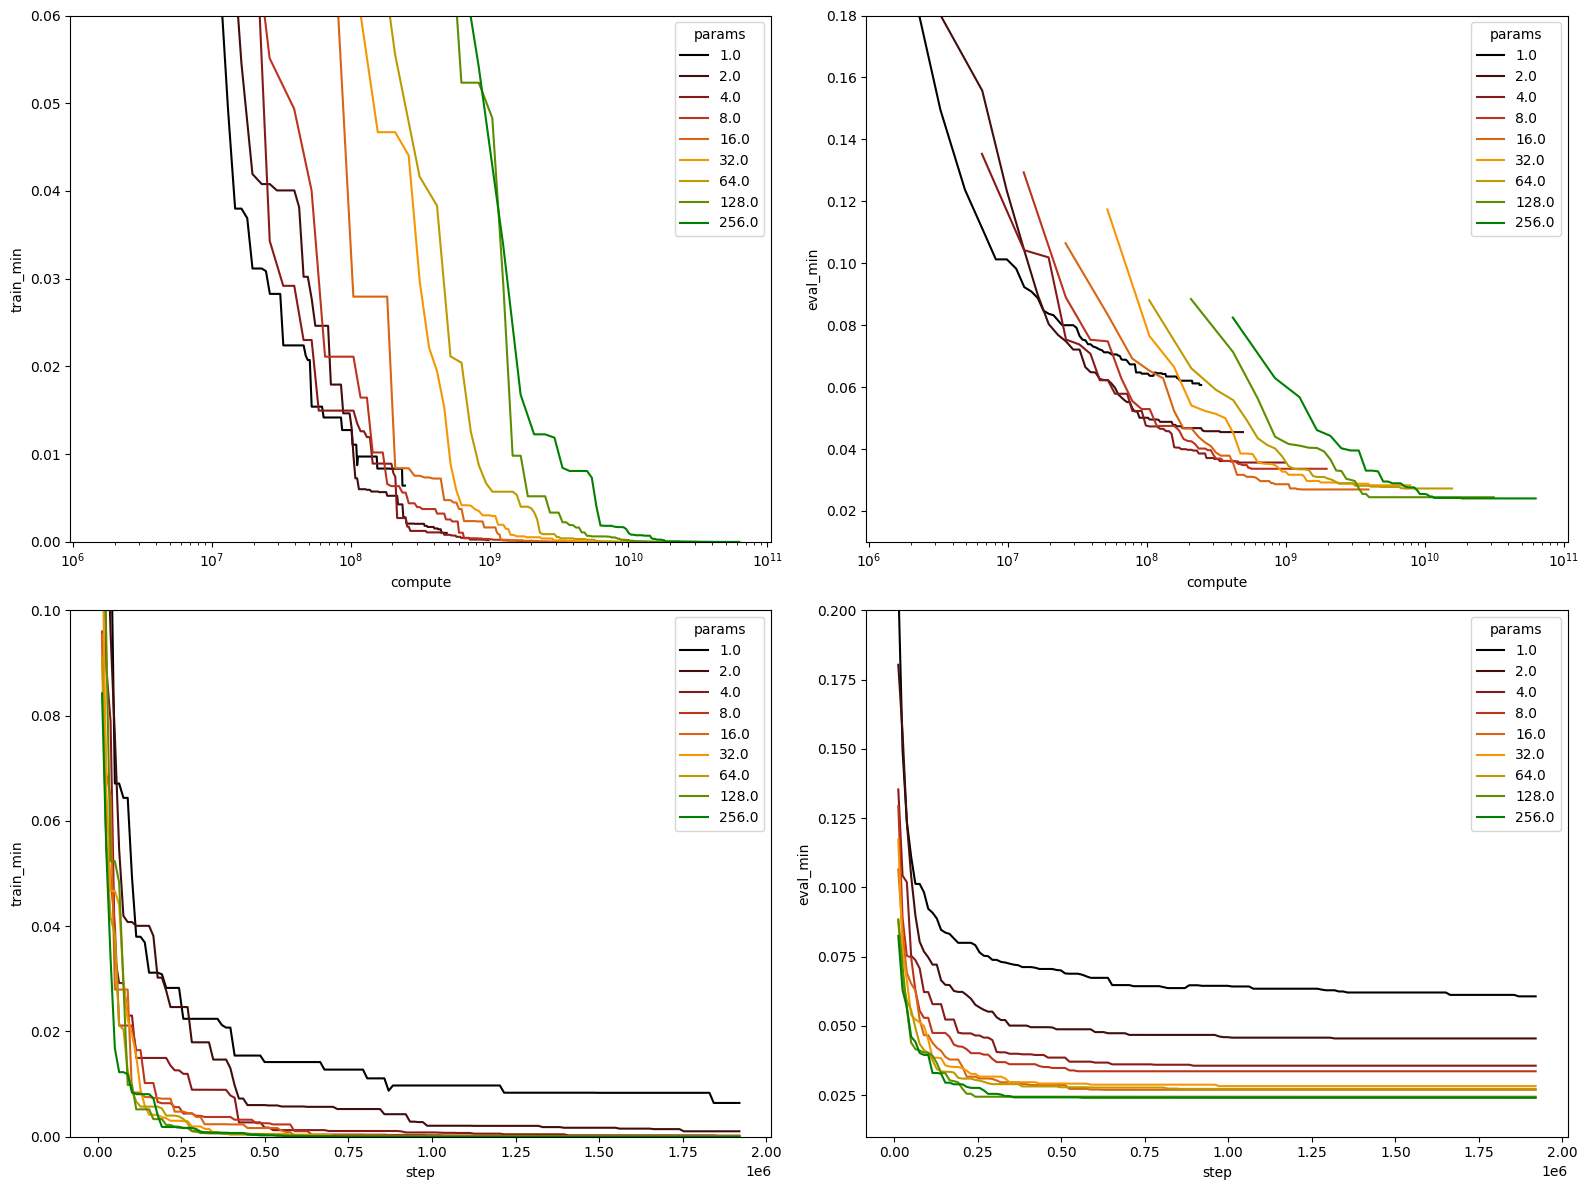

In [365]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))
ax = ax.flatten()

sns.lineplot(data=avg_scaling_df, x = 'compute', y='train_min', hue='params', palette=cmap, ax=ax[0])
sns.lineplot(data=avg_scaling_df, x = 'compute', y='eval_min', hue='params',  palette=cmap, ax=ax[1])
sns.lineplot(data=avg_scaling_df, x = 'step', y='train_min', hue='params', palette=cmap, ax=ax[2])
sns.lineplot(data=avg_scaling_df, x = 'step', y='eval_min', hue='params', palette=cmap,  ax=ax[3])
for i in range(2):
    ax[i].set_xscale('log')
ax[0].set_ylim(0, .06)
ax[1].set_ylim(.01, .18)
ax[2].set_ylim(0, .1)
ax[3].set_ylim(.01, .2)


plt.tight_layout()

In [373]:
compute_efficient_df = pd.DataFrame({'Compute': [], 'Model Size': [], 'Steps': []})
compute_efficient_df['Compute'] = [avg_scaling_df['compute'].unique()[i] for i in range(0, len(avg_scaling_df), 10)]

efficient_models = []
efficient_steps = []
for compute in compute_efficient_df['Compute']:
    efficient_models.append(avg_scaling_df[avg_scaling_df.loc[avg_scaling_df['compute'] <= compute]['eval_loss'].min() == avg_scaling_df.eval_loss]['params'].values.item())
    efficient_steps.append(avg_scaling_df[avg_scaling_df.loc[avg_scaling_df['compute'] <= compute]['eval_loss'].min() == avg_scaling_df.eval_loss].index[0][1])
compute_efficient_df['Model Size'] = efficient_models
compute_efficient_df['Steps'] = efficient_steps

compute_efficient_df['log Compute'] = np.log10(compute_efficient_df.Compute)
compute_efficient_df['log Model Size'] = np.log10(compute_efficient_df['Model Size'])
compute_efficient_df['log Steps'] = np.log10(compute_efficient_df.Steps)

partial_df = compute_efficient_df[compute_efficient_df.Compute.between(1e7, 5e9)]

reg1 = LinearRegression().fit(partial_df['log Compute'].values.reshape(-1, 1), partial_df['log Model Size'].values)
reg2 = LinearRegression().fit(partial_df['log Compute'].values.reshape(-1, 1), partial_df['log Steps'].values)

0.22654497098341164

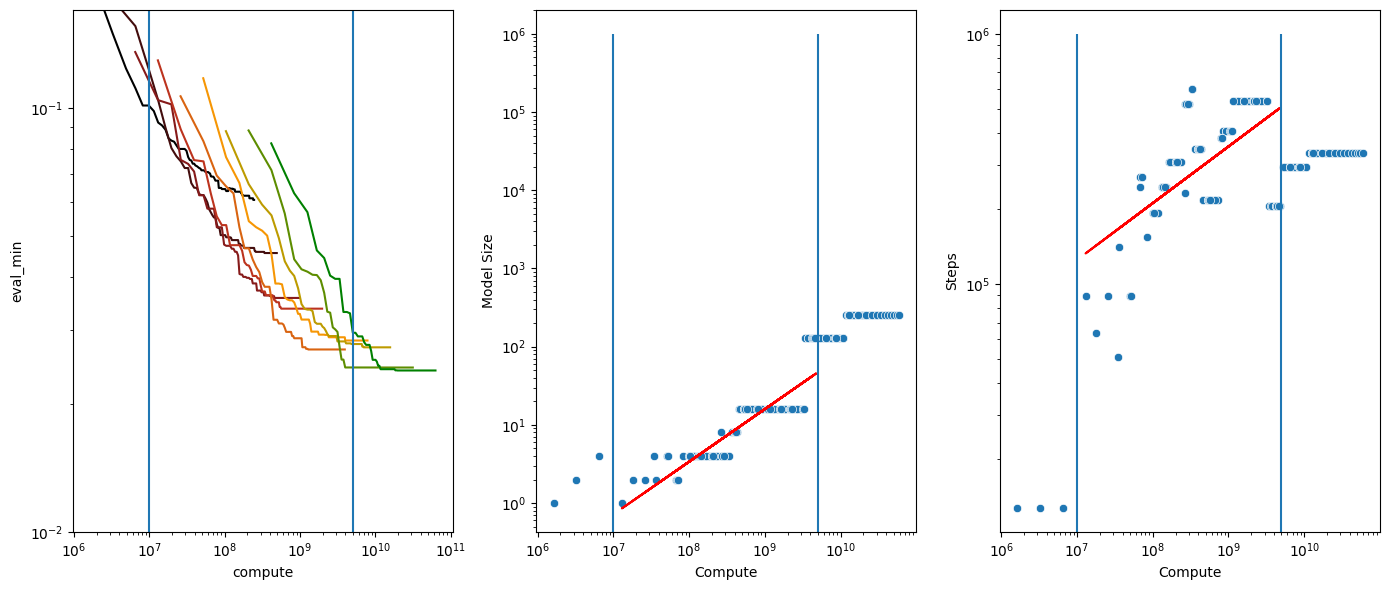

In [372]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 6))
ax = ax.flatten()

sns.lineplot(data=avg_scaling_df, x = 'compute', y='eval_min', hue='params',  palette=cmap, ax=ax[0]).legend_.remove()

sns.scatterplot(data=compute_efficient_df, x = 'Compute', y='Model Size', ax=ax[1])
ax[1].plot(partial_df['Compute'], partial_df['Compute']**reg1.coef_ * 10**reg1.intercept_, color='r')

sns.scatterplot(data=compute_efficient_df, x = 'Compute', y='Steps', ax=ax[2])
ax[2].plot(partial_df['Compute'], partial_df['Compute']**reg2.coef_ * 10**reg2.intercept_, color='r')

for i in range(3):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].vlines(x=1e7, ymin=0, ymax=1e6)
    ax[i].vlines(x=5e9, ymin=0, ymax=1e6)


ax[0].set_ylim(.01, .17)


plt.legend([],[], frameon=False)

plt.tight_layout()

Discussion of the Vertical Lines

The limited window of a clear scaling regime

The limited significance of the data scaling line given the nature of the data -- but surprising difference 

Results: formulae for optimal model size and data

In [50]:
lr_df = pd.read_csv('linear_lr.csv')
lr_df

,Unnamed: 0,model_size,lr,step,train_loss,eval_loss,eval_min,train_min,compute,params
0,0,4.0,0.050,12672.0,0.314319,0.343583,0.343583,0.314319,2.595226e+07,16.0
1,1,4.0,0.050,25472.0,0.285268,0.345239,0.343583,0.285268,5.216666e+07,16.0
2,2,4.0,0.050,38272.0,0.299699,0.279987,0.279987,0.285268,7.838106e+07,16.0
3,3,4.0,0.050,51072.0,0.314166,0.287893,0.279987,0.285268,1.045955e+08,16.0
4,4,4.0,0.050,63872.0,0.221384,0.242511,0.242511,0.221384,1.308099e+08,16.0
...,...,...,...,...,...,...,...,...,...,...
445,445,4.0,0.005,1868672.0,0.073977,0.142160,0.140989,0.029010,3.827040e+09,16.0
446,446,4.0,0.005,1881472.0,0.161499,0.142113,0.140989,0.029010,3.853255e+09,16.0
447,447,4.0,0.005,1894272.0,0.284103,0.142112,0.140989,0.029010,3.879469e+09,16.0
448,448,4.0,0.005,1907072.0,0.122227,0.142992,0.140989,0.029010,3.905683e+09,16.0


/var/folders/zj/sb8kq74514s5m6zcb6vsd6dh0000gn/T/ipykernel_1612/1520897148.py:6: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.lineplot(data=lr_df, x = 'step', y='train_min', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[0])
/var/folders/zj/sb8kq74514s5m6zcb6vsd6dh0000gn/T/ipykernel_1612/1520897148.py:7: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.lineplot(data=lr_df, x = 'step', y='eval_min', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[1])
/var/folders/zj/sb8kq74514s5m6zcb6vsd6dh0000gn/T/ipykernel_1612/1520897148.py:8: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.lineplot(data=lr_df, x = 'step', y='train_loss', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[2])
/var/folders/zj/sb8kq74514s5m6zcb6vsd6dh0000gn/T/ipykernel_1612/1520897148.py:9: UserWarning: The palette list has more values (9)

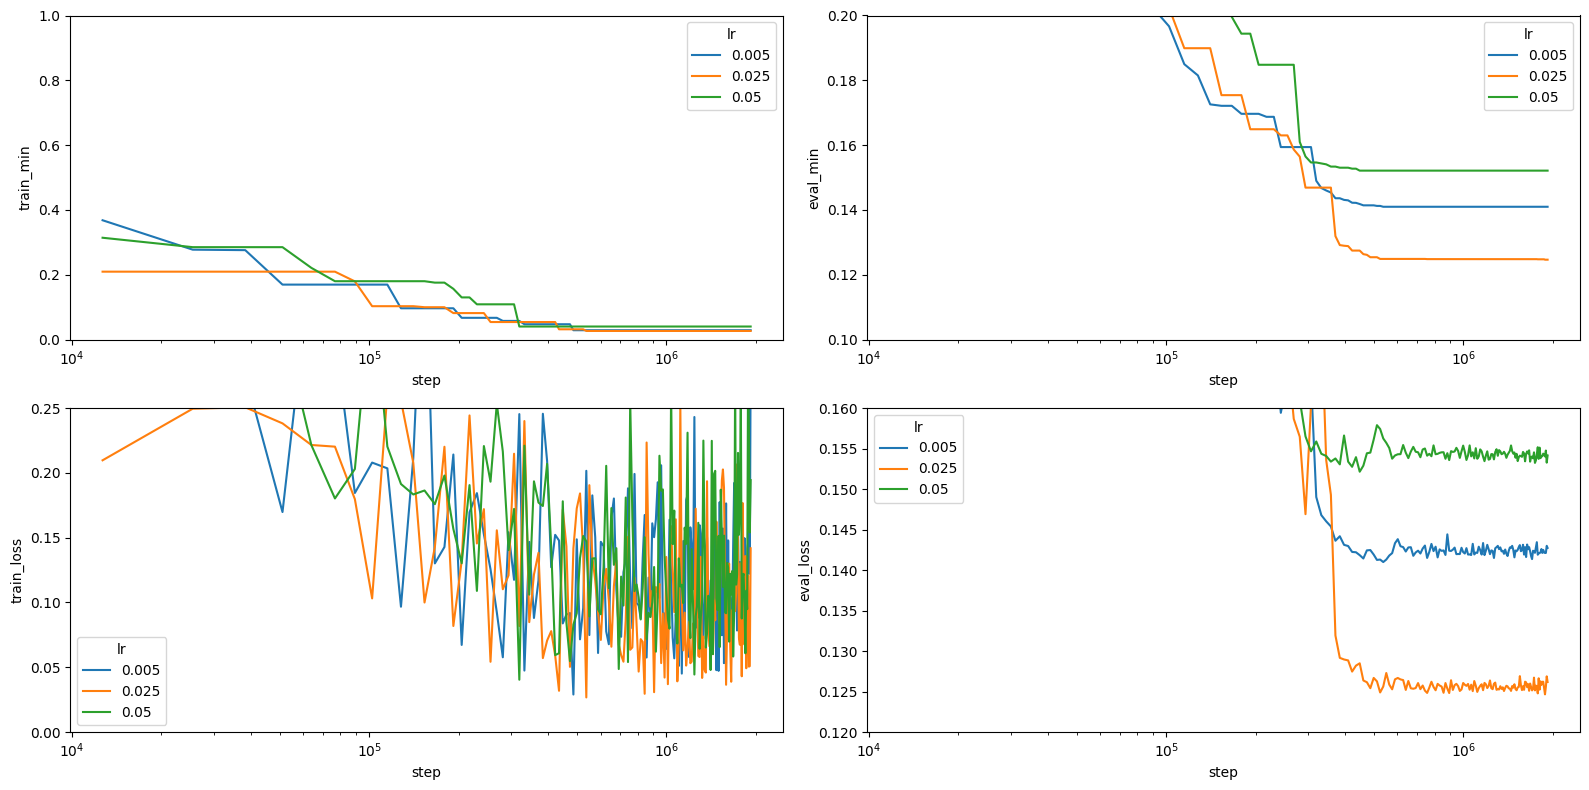

In [55]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
ax = ax.flatten()

palette = sns.color_palette('tab10')

sns.lineplot(data=lr_df, x = 'step', y='train_min', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[0])
sns.lineplot(data=lr_df, x = 'step', y='eval_min', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[1])
sns.lineplot(data=lr_df, x = 'step', y='train_loss', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[2])
sns.lineplot(data=lr_df, x = 'step', y='eval_loss', hue='lr', palette=palette[:9], errorbar=('ci', 0), ax=ax[3])
for i in range(4):
    ax[i].set_xscale('log')
ax[0].set_ylim(0, 1)
ax[1].set_ylim(.1, .2)
ax[2].set_ylim(0, .25)
ax[3].set_ylim(.12, .16)



plt.tight_layout()